In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import math
from seaborn import heatmap
import seaborn as sns
from matplotlib import transforms
from skimage import metrics
import statistics
import copy
from scipy import optimize

In [2]:
def importAudio(target, reference, numBands, output=True):
    if(output):
        display(ipd.Audio(target))
        display(ipd.Audio(reference))

    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=(numBands*2)-1, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=(numBands*2)-1, hop_length=hopSize)

    tDFT = librosa.stft(tArray, n_fft=(numBands*2)-1, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=(numBands*2)-1, hop_length=10000000000)
    
    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

In [3]:
def exportAudio(tAudio, mAudio, rAudio):
    print("Target")
    tInverse = librosa.istft(tAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(tInverse, rate=tAudio["sampleRate"]))

    print("Matched")
    mInverse = librosa.istft(mAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(mInverse, rate=mAudio["sampleRate"]))

    print("Reference")
    rInverse = librosa.istft(rAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(rInverse, rate=rAudio["sampleRate"]))

In [4]:
def plotSpectrogram(tAudio, mAudio, rAudio):

    maximum = (max(np.max(np.abs(tAudio["STFT"])**2), np.max(np.abs(rAudio["STFT"])**2)))
    
    # derives the spectrogram from the STFT
    tSpectrogram = librosa.power_to_db(np.abs(tAudio["STFT"])**2)
    mSpectrogram = librosa.power_to_db(np.abs(mAudio["STFT"])**2)
    rSpectrogram = librosa.power_to_db(np.abs(rAudio["STFT"])**2)
    spectrograms = [tSpectrogram,mSpectrogram,rSpectrogram]

    minGain = 0
    maxGain = 0
    for spectrogram in spectrograms:
        for bin in spectrogram:
            for gain in bin:
                if(gain<minGain):
                    minGain=gain
                if(gain>maxGain):
                    maxGain=gain
    
    # creates plots of spectrograms
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10*figScale, 5*figScale))
    tImg = librosa.display.specshow(tSpectrogram,sr=tAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[0],vmin=minGain,vmax=maxGain)
    
    mImg = librosa.display.specshow(mSpectrogram,sr=mAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[1],vmin=minGain,vmax=maxGain)
    rImg = librosa.display.specshow(rSpectrogram,sr=rAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[2],vmin=minGain,vmax=maxGain)

    # adjusts appearance
    ax[0].set(title='Target')
    ax[1].set(title='Matched')
    ax[2].set(title='Reference')
    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(mImg, ax=[ax[0], ax[1], ax[2]],format='%+2.0f dB')


<h3>Matching based on gain average of frequency bands</h3>

In [5]:
def plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve):
    plt.figure(figsize=(10*figScale,4*figScale))

    plt.plot(20*np.log10(tCurve), alpha=0.2, color='blue', label="Target")
    plt.plot(20*np.log10(tCurveSmooth), color='blue', label="Convolved Target")

    plt.plot(20*np.log10(rCurve), alpha=0.2, color='red', label="Reference")
    plt.plot(20*np.log10(rCurveSmooth), color='red', label="Convolved Reference")

    plt.plot(20*np.log10(mCurve), color='mediumseagreen', label="Matched")
    
    plt.xlabel("Frequency Bin")
    plt.ylabel("Gain (dB)")
    plt.legend(loc="lower left",ncol=3)

In [6]:
def convolve(curve, smoothing):
    curve = np.ravel(curve)
    kernel = np.ones(smoothing) / smoothing
    curve = np.convolve(curve, kernel, mode='same')
    curve = curve.reshape(len(curve),1)
    return curve

def EQMatching(tAudio, rAudio, smoothing=1, plot=True):
    tCurve = np.abs(tAudio["DFT"])
    tCurveSmooth = convolve(tCurve, smoothing)

    rCurve = np.abs(rAudio["DFT"])
    rCurveSmooth = convolve(rCurve, smoothing)

    scaler = rCurveSmooth / tCurveSmooth
    
    mSTFT = tAudio["STFT"] * scaler
    mDFT = tAudio["DFT"] * scaler
    mAudio = {"STFT":mSTFT,"DFT":mDFT,"sampleRate":tAudio["sampleRate"]}

    if(plot):
        mCurve = np.abs(mDFT)
        plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve)
    
    return mAudio

In [7]:
def plotDynamics(tSlice,rSlice,coeff,dynamicBins):

    #Grid
    fig = plt.figure(figsize=(14*figScale, 4*figScale))
    gs = GridSpec(6, 21, figure=fig)

    tLevel = fig.add_subplot(gs[0:3, 0:10])
    rLevel = fig.add_subplot(gs[3:6, 0:10])

    tResponse = fig.add_subplot(gs[0:5, 10:11])
    rResponse = fig.add_subplot(gs[0:5, 11:12])
    mResponse = fig.add_subplot(gs[0:5, 12:13])
    mrResponse = fig.add_subplot(gs[0:5, 13:14])
    preDist = fig.add_subplot(gs[5:6, 10:12])
    postDist = fig.add_subplot(gs[5:6, 12:14])

    mod = fig.add_subplot(gs[0:6, 15:21])
    fig.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0.8)

    #abs
    tSlice = np.abs(tSlice)
    mSlice = np.abs(warp(tSlice,coeff))
    rSlice = np.abs(rSlice)



    #Level
    tLevel.plot(np.abs(tSlice),label="Unmatched",color='blue')
    tLevel.plot(np.abs(mSlice),label="Matched",color='red')
    rLevel.plot(np.abs(rSlice),color='green')

    tLevel.set_title('Target')
    tLevel.set_ylabel("Level")
    tLevel.legend()
    tLevel.set_ylim((0,max(max(tSlice),max(rSlice),max(mSlice))))
    rLevel.set_title('Reference')
    rLevel.set_xlabel("Frame")
    rLevel.set_ylabel("Level")
    rLevel.set_ylim((0,max(max(tSlice),max(rSlice),max(mSlice))))
    


    #Response
    tDynamicResponse, rDynamicResponse = getDynamicResponse(tSlice, rSlice, dynamicBins)
    reshape = np.flip(tDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=tResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(rDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=rResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    tResponse.set_xticks([])
    tResponse.set_yticks([])
    rResponse.set_xticks([])
    rResponse.set_yticks([])
    tResponse.set_title('unmatched', fontsize=10)
    rResponse.set_title('ref', fontsize=10)

    mDynamicResponse, mrDynamicResponse = getDynamicResponse(mSlice, rSlice, dynamicBins)
    reshape = np.flip(mDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=mResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(mrDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heat = heatmap(reshape, ax=mrResponse, cmap="magma")
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    mResponse.set_xticks([])
    mResponse.set_yticks([])
    mrResponse.set_xticks([])
    mrResponse.set_yticks([])
    mResponse.set_title('matched', fontsize=10)
    mrResponse.set_title('ref', fontsize=10)

    preDist.set_title('Distance:')
    postDist.set_title('Distance:')
    preDist.axis("off")
    postDist.axis("off")
    preDist.text(0.5, 0.5, round(objective([1],tSlice,rSlice,dynamicBins),2), va="center", ha="center")
    postDist.text(0.5, 0.5, round(objective(coeff,tSlice,rSlice,dynamicBins),2), va="center", ha="center")



    #Modifier
    tMax = max(np.abs(tSlice))
    x = np.linspace(0,tMax,100)
    #plotCoeff = np.append(coeff[::-1],0)
    plotCoeff = coeff[::-1]
    y = np.polyval(plotCoeff,x)

    mod.axhline(1, color='blue')
    mod.plot(x,y, color='red')
    
    mod.set_title('Modifier')
    mod.set_xlabel("Target Level")
    mod.set_ylabel("Matched Level")

In [8]:
def integral(coeffs,a,b):
    intA = 0
    intB = 0
    for i in range(len(coeffs)):
        intA += coeffs[i] * ((a**(i+2))/(i+1))
        intB += coeffs[i] * ((b**(i+2))/(i+2))
    return intB - intA

# Quantify lack of increase- monotonicity. used to penalise loss
def LOI(coeffs,lim):
    p = np.poly1d(np.append(coeffs[::-1],0))
    der = np.polyder(p)
    roots = np.roots(der)
    
    roots = roots[np.where(roots>=0)]
    roots = roots[np.where(roots<=lim)]

    if(len(roots)%2!=0):
        secondDer = np.polyder(der)
        if(secondDer(roots[0])>0):
            roots = np.append(0,roots)
        else:
            roots = np.append(roots,lim)

    total = 0
    for i in range(0,len(roots),2):
        total += abs(integral(coeffs,roots[i],roots[i+1]))
    return total/lim

In [9]:
# Calculate the dynamic response historgrams, used for calculating loss of frequency bins
def getDynamicResponse(tFreqBin, rFreqBin, dynamicBins):
    # tFreqBin may already be absolute if coming from objective funct. abs(abs()) will flatten cardinality and break functionality
    if(np.any(np.iscomplex(tFreqBin))):
        tAbs = np.abs(tFreqBin)
    else:
        tAbs=tFreqBin
    rAbs = np.abs(rFreqBin)

    # The minimum and maximum gain values across target and reference combined
    dynamicRange = (min(min(tAbs),min(rAbs)), max(max(tAbs),max(rAbs)))

    # Histograms of how commonly certain gain ranges occur, in dB
    tDynamicResponse = np.histogram(tAbs,bins=dynamicBins,range=dynamicRange)[0]
    rDynamicResponse = np.histogram(rAbs,bins=dynamicBins,range=dynamicRange)[0]

    return tDynamicResponse, rDynamicResponse

# Calculate loss between two dynamic responses
def getDistance(tDynamicResponse, rDynamicResponse, tMax, rMax, dynamicBins):
    A = tDynamicResponse / sum(tDynamicResponse)
    B = rDynamicResponse / sum(rDynamicResponse)
    
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = A[x]-B[x]+dist[x]
    wasserstein = np.sum(abs(dist))

    if(tMax > rMax):
        wasserstein = wasserstein * (tMax / rMax)
    
    wasserstein = wasserstein / dynamicBins
    
    return wasserstein

# Warp the dynamics of a frequency bin by applying a polynomial equation
def warp(bin,coeff):
    warped = np.zeros_like(bin)
    for i in range(len(coeff)):
        component = coeff[i] * (bin*(np.abs(bin)**i))
        warped += component
    
    return warped

def warp(bin,coeff):
    warped = np.zeros_like(bin)
    for i in range(len(coeff)):
        component = bin * (coeff[i] * (bin ** i))
        warped += component
    
    return warped

<h1>WORKSTATION</h1>

In [11]:
import numpy as np
import seaborn as sns; sns.set_theme(style='white')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

In [73]:
def plotDynamicsBands(tSlices,rHist,coeff,interval):
    #Grid
    fig = plt.figure(figsize=(14*figScale, 4*figScale))
    gs = GridSpec(6, 21, figure=fig)

    tLevel = fig.add_subplot(gs[0:3, 0:10])
    rLevel = fig.add_subplot(gs[3:6, 0:10])

    tResponse = fig.add_subplot(gs[0:5, 10:11])
    rResponse = fig.add_subplot(gs[0:5, 11:12])
    mResponse = fig.add_subplot(gs[0:5, 12:13])
    mrResponse = fig.add_subplot(gs[0:5, 13:14])
    preDist = fig.add_subplot(gs[5:6, 10:12])
    postDist = fig.add_subplot(gs[5:6, 12:14])

    mod = fig.add_subplot(gs[0:6, 15:21])
    fig.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0.8)
    

    #Response
    tDynamicResponse = sumHist(dynamicResponses(tSlices,interval,plot=False))
    rDynamicResponse = rHist
    if(len(tDynamicResponse)>len(rDynamicResponse)):
        rDynamicResponse = np.pad(rDynamicResponse,(0,len(tDynamicResponse)-len(rDynamicResponse)))
    if(len(rDynamicResponse)>len(tDynamicResponse)):
        tDynamicResponse = np.pad(tDynamicResponse,(0,len(rDynamicResponse)-len(tDynamicResponse)))

    reshape = np.flip(tDynamicResponse.reshape(tDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=tResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(rDynamicResponse.reshape(rDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=rResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    tResponse.set_xticks([])
    tResponse.set_yticks([])
    rResponse.set_xticks([])
    rResponse.set_yticks([])
    tResponse.set_title('unmatched', fontsize=10)
    rResponse.set_title('ref', fontsize=10)



    mSlices = np.zeros_like(tSlices)
    for i in range(len(mSlices)):
        mSlices[i] = warp(np.abs(tSlices[i]), coeff)
    mDynamicResponse = sumHist(dynamicResponses(mSlices,interval,plot=False))
    mrDynamicResponse = rHist
    if(len(mDynamicResponse)>len(mrDynamicResponse)):
        mrDynamicResponse = np.pad(mrDynamicResponse,(0,len(mDynamicResponse)-len(mrDynamicResponse)))
    if(len(mrDynamicResponse)>len(mDynamicResponse)):
        mDynamicResponse = np.pad(mDynamicResponse,(0,len(mrDynamicResponse)-len(mDynamicResponse)))
    
    reshape = np.flip(mDynamicResponse.reshape(mDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=mResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    reshape = np.flip(mrDynamicResponse.reshape(mrDynamicResponse.shape[0], 1))
    heat = heatmap(reshape+1, ax=mrResponse, cmap="magma",norm=LogNorm())
    for _, spine in heat.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    mResponse.set_xticks([])
    mResponse.set_yticks([])
    mrResponse.set_xticks([])
    mrResponse.set_yticks([])
    mResponse.set_title('matched', fontsize=10)
    mrResponse.set_title('ref', fontsize=10)

    print("pre:",getDistance(tDynamicResponse,rDynamicResponse,interval))
    print("post:",getDistance(mDynamicResponse,rDynamicResponse,interval))
    #preDist.set_title('Distance:')
    #postDist.set_title('Distance:')
    #preDist.axis("off")
    #postDist.axis("off")
    #preDist.text(0.5, 0.5, round(objective([1],tSlice,rSlice,dynamicBins),2), va="center", ha="center")
    #postDist.text(0.5, 0.5, round(objective(coeff,tSlice,rSlice,dynamicBins),2), va="center", ha="center")


    
    #Modifier
    #tMax = max(np.abs(tSlice))
    #x = np.linspace(0,tMax,100)
    #plotCoeff = coeff[::-1]
    #y = np.polyval(plotCoeff,x)

    #mod.axhline(1, color='blue')
    #mod.plot(x,y, color='red')
    
    #mod.set_title('Modifier')
    #mod.set_xlabel("Target Level")
    #mod.set_ylabel("Matched Level")

In [ ]:
# the objective function upon which the dual annealing operates
def objective(x, *params):
    tSlices, rHist, interval = params
    
    # Warp every slice of the band by the proposed coefficients
    mSlices = np.zeros_like(tSlices)
    for i in range(len(mSlices)):
        mSlices[i] = warp(np.abs(tSlices[i]), x)
    # Derive histograms for each slice
    mHists = dynamicResponses(mSlices,interval,plot=False)
    # Sum histograms into one
    mHist = sumHist(mHists)

    return getDistance(mHist, rHist, interval)# + (LOI(x,max(np.abs(tSlice)))*1000)

In [34]:
def dynamicResponses(freqBins,interval,plot=False):
    bins = len(freqBins)
    maxGain = 0
    for i in range(bins):
        bin = np.abs(freqBins[i,:])
        if(max(bin)>maxGain):
            maxGain = max(bin)
    binCount = math.ceil(maxGain/interval)
    dynamicResponses = np.zeros((bins,binCount))
    for i in range(bins):
        bin = np.abs(freqBins[i,:])
        dynamicResponses[i]=np.histogram(bin,bins=binCount,range=(0,maxGain))[0]

    if(plot):
        plt.figure(figsize=(7*figScale,5*figScale))
        axis = np.linspace(0,math.floor(maxGain),binCount)
        ax = sns.heatmap(dynamicResponses+1,xticklabels=axis,cmap="magma",norm=LogNorm())
        ax.invert_yaxis()
        plt.locator_params(nbins=10)
        plt.xlabel('gain')
        plt.ylabel('frequency bin')
        plt.show()

    return dynamicResponses


In [21]:
def bandBoundaries(numBands, numBins):
     boundaries = [0]
     for i in range(numBands):
          boundaries.append(math.floor((numBins / numBands) * (i+1)))
     return boundaries

In [24]:
def sumHist(hists):
    sumHist = np.zeros_like(hists[0])
    for hist in hists:
        sumHist += hist
    return sumHist


In [35]:
# Calculate loss between two dynamic responses
def getDistance(tHist, rHist, interval):
    A = tHist / sum(tHist)
    B = rHist / sum(rHist)
    
    if(len(A)>len(B)):
        B = np.pad(B,(0,len(A)-len(B)))
    if(len(B)>len(A)):
        A = np.pad(A,(0,len(B)-len(A)))
    
    n = len(A)
    dist = np.zeros(n)
    for x in range(n-1):
        dist[x+1] = A[x]-B[x]+dist[x]
    wasserstein = np.sum(abs(dist))
    
    wasserstein = wasserstein * interval

    return wasserstein

In [53]:
# the objective function upon which the dual annealing operates
def objective(x, *params):
    tSlices, rHist, interval = params
    
    # Warp every slice of the band by the proposed coefficients
    mSlices = np.zeros_like(tSlices)
    for i in range(len(mSlices)):
        mSlices[i] = warp(np.abs(tSlices[i]), x)
    # Derive histograms for each slice
    mHists = dynamicResponses(mSlices,interval,plot=False)
    # Sum histograms into one
    mHist = sumHist(mHists)

    return getDistance(mHist, rHist, interval)# + (LOI(x,max(np.abs(tSlice)))*1000)

# perform multi bin dual annealing
def findMin(tSlices,rHist,interval,order,searchSize,plot=False):
    bounds = list(zip([-searchSize]*order,[searchSize]*order))

    sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlices,rHist,interval))
    #sol = optimize.minimize(objective, method="Powell", x0=[15.43343102, -58.07865526,  59.84474211], bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamicsBands(tSlices, rHist, sol['x'], interval)
    return sol['x']

base the max gain off the max from both the reference and the target. this means that scaling only has to star happening during the optimisation process.
have many bins. the matching quality will not be impeded from a higher bin count.
when performing the individual matchings, the y limit of the target will be based off the maximum y limit. this is to ensure both target and refernce histograms have a shared limit.
bins only need to be added on top in the case that the matched audio reaches a new global max gain. in this case, only need to add empty bins in ref. quantised. if 1 bin represents 1dB, only add bins if new gain exceeds 1dB etc.

pre: 3.4792668269230793
post: 1.8773815883190887


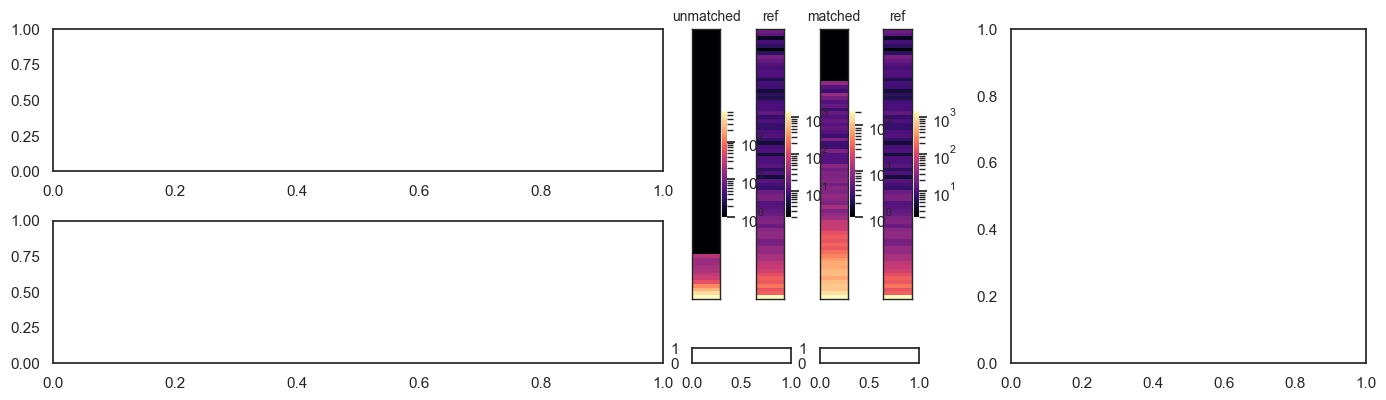

In [74]:
numBins = 64
hopSize=512
figScale=1

numBands = 4
interval = 0.5

tAudio, rAudio = importAudio(target="tonequiet.wav",reference="100.wav", numBands=numBins, output=False)

boundaries = bandBoundaries(numBands, numBins)

tSlices = tAudio["STFT"][boundaries[0]:boundaries[1]]
rHist = sumHist(dynamicResponses(rAudio["STFT"][boundaries[0]:boundaries[1]],interval))

result = findMin(tSlices,rHist,interval=interval,order=1,searchSize=100,plot=True)

In [51]:
result

array([5.82989859, 0.15101152])

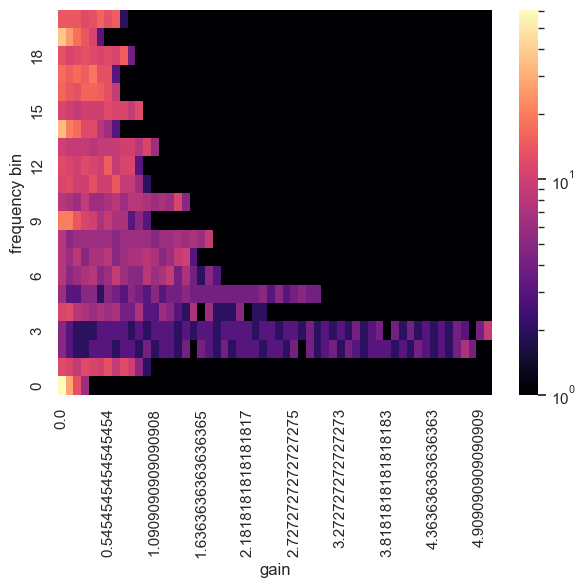

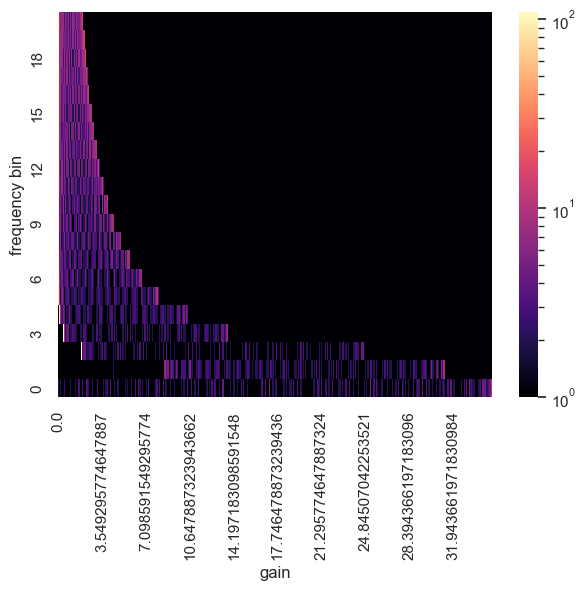

In [98]:
tSlices = tAudio["STFT"][bandBoundaries[0]:bandBoundaries[1]]
tHist = dynamicResponses(tSlices,interval)
rHist = dynamicResponses(rAudio["STFT"][bandBoundaries[0]:bandBoundaries[1]],interval)

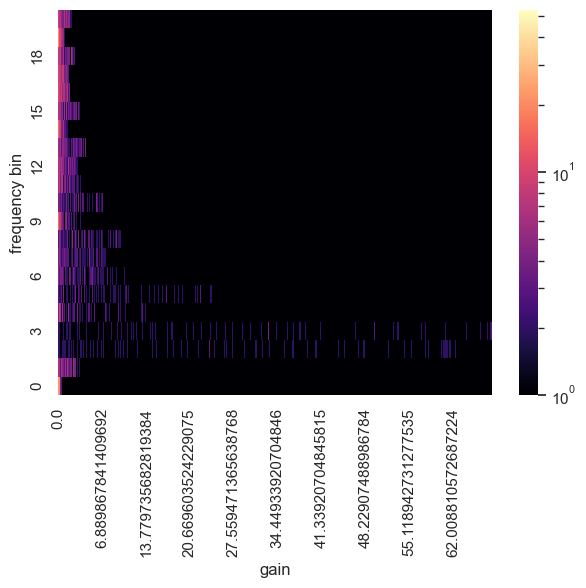

In [118]:
mSlices = np.zeros_like(tSlices)
for i in range(len(mSlices)):
    mSlices[i] = warp(np.abs(tSlices[i]), [1,2])
mHist = dynamicResponses(mSlices,interval)

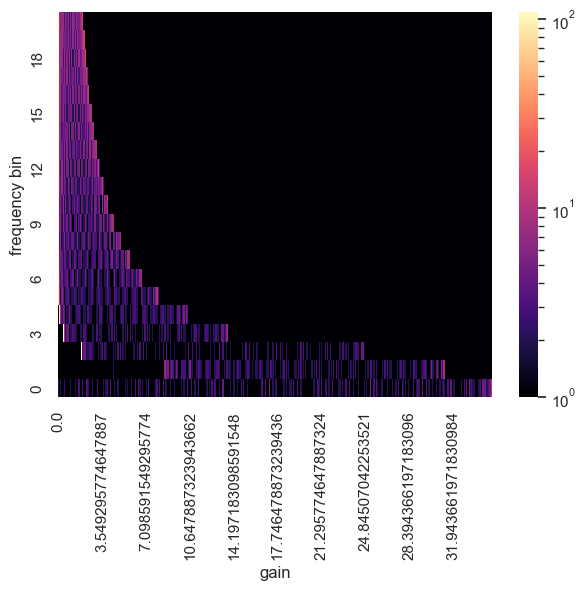

KeyboardInterrupt: 

In [150]:
tSlices = tAudio["STFT"][bandBoundaries[0]:bandBoundaries[1]]
rHist = sumHist(dynamicResponses(rAudio["STFT"][bandBoundaries[0]:bandBoundaries[1]],interval))

result = findMin(tSlices,rHist,interval=interval,order=1,searchSize=100,plot=False)

<h1>BACK TO IT</h1>

In [13]:
def bruteForceMatching(tAudio,rAudio,dynamicBins,freqBin, testDistance, steps):
    multipliers = np.linspace(0,testDistance,steps)
    distances = np.zeros((steps,steps))
    
    for i in range(steps):
        for j in range(steps):
            matched = warp(tAudio["STFT"][freqBin,:],[multipliers[j],multipliers[i]])
            #matched = multipliers[i]*tAudio["STFT"][freqBin,:]**2 + multipliers[j]*tAudio["STFT"][freqBin,:]
            tDynamicResponse, rDynamicReponse = getDynamicResponse(matched,rAudio["STFT"][freqBin,:],dynamicBins)
            tMax = max(np.abs(matched))
            rMax = max(np.abs(rAudio["STFT"][freqBin,:]))
            distances[i,j] = getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax,dynamicBins)
    
    plt.figure(figsize=(7*figScale,5*figScale))

    ax = sns.heatmap(distances,xticklabels=multipliers.round(2),yticklabels=multipliers.round(2),cmap="magma_r")
    ax.invert_yaxis()
    plt.locator_params(nbins=10)
    plt.xlabel('x')
    plt.ylabel('x^2')
    plt.show()

In [14]:
# the objective function upon which the dual annealing operates
def objective(x, *params):
    tSlice, rSlice, dynamicBins = params

    mSlice = warp(np.abs(tSlice), x)
    mDynamicResponse, rDynamicReponse = getDynamicResponse(mSlice,rSlice,dynamicBins)
    mMax = max(np.abs(mSlice))
    rMax = max(np.abs(rSlice))
    
    return getDistance(mDynamicResponse,rDynamicReponse,mMax,rMax,dynamicBins)# + (LOI(x,max(np.abs(tSlice)))*1000)

# perform dual annealing
def findMin(tSlice,rSlice,dynamicBins,order,searchSize,plot=False):
    order = order
    searchSize = searchSize
    bounds = list(zip([-searchSize]*order,[searchSize]*order))

    sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlice,rSlice,dynamicBins))
    #sol = optimize.minimize(objective, method="Powell", x0=[15.43343102, -58.07865526,  59.84474211], bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamics(tSlice, rSlice, sol['x'], dynamicBins)
    return sol['x']

# perform powell minimisation
def powell(tSlice,rSlice,initial,dynamicBins,order,searchSize,plot=False):
    order = order
    searchSize = searchSize
    bounds = list(zip([-searchSize]*order,[searchSize]*order))
    #print(initial)
    #sol = optimize.dual_annealing(objective, bounds=bounds, args=(tSlice,rSlice,dynamicBins))
    sol = optimize.minimize(objective, method="Powell", x0=initial, bounds=bounds, args=(tSlice,rSlice,dynamicBins))

    if(plot):
        plotDynamics(tSlice, rSlice, sol['x'], dynamicBins)
    return sol['x']


In [69]:
def plotModifiers(coeffs,maxes,optimisation,plotRange=None):
    maxT = 0
    maxM = 0

    if(type(plotRange) != tuple):
        plotRange = (0,len(coeffs))

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(plotRange[0],plotRange[1]):
        x = np.linspace(0,maxes[i],100)
        plotCoeff = coeffs[i][::-1]
        y = np.polyval(plotCoeff,x)
        if(optimisation[i]=="SA"):
            color="red"
        else:
            color="blue"
        ax.plot(x,y,zs=i, zdir='y',color=color)
        ax.plot(x,np.ones(100),zs=i, zdir='y',color=color, alpha=0.2)

        if(maxes[i]>maxT):
            maxT=maxes[i]
        if(max(y)>maxM):
            maxM=max(y)

    ax.set_zlim(0, maxM)
    ax.set_xlim(0, maxT)
    ax.set_zlabel("Multiplication")
    ax.set_ylabel("Frequency Bin")
    ax.set_xlabel("Target Level")
    ax.view_init(20,-120)
    ax.grid(False)
    plt.show()

In [164]:
def plotModifiers(coeffs,centres,tHifi,tAudio):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    bins = len(tHifi["STFT"])
    
    sa=0
    for i in range(bins):
        if(i in centres):
            x = np.linspace(0,max(np.abs(tAudio["STFT"][sa,:])),100)
            y = np.polyval(coeffs[sa][::-1],x)

            ax.plot(x,y,zs=i, zdir='y',color="red")
            ax.plot(x,np.ones(100),zs=i, zdir='y',color="red", alpha=0.2)

            sa+=1
        else:
            x = np.linspace(0,1,100)
            y = np.polyval([1],x)

            ax.plot(x,y,zs=i, zdir='y',color="blue")
            ax.plot(x,np.ones(100),zs=i, zdir='y',color="blue", alpha=0.2)
    
    ax.set_zlabel("Multiplication")
    ax.set_ylabel("Frequency Bin")
    ax.set_xlabel("Target Level")
    ax.view_init(20,-120)
    ax.grid(False)
    plt.show()

In [159]:
5 in [1,2,5]

True

<h1>Different matching strategies</h1>

In [16]:
# Simulated annealing every x bins, local minimisations fill the gaps.
def findMatching(tAudio,rAudio,dynamicBins,order,searchSize,jump,plot=False,plotRange=None):
    bins = len(tAudio["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins

    # First S.A
    print("SA 0")
    i=0
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    for block in range(math.floor(bins/jump)):
        # Subblock SA
        i=(block*jump)+jump
        print("SA",i)
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="SA"

        for subblock in range(math.floor(jump/2)):
            # right side (!=0 because 0 is SA)
            if(subblock!=0):
                i=(block*jump)+(jump-subblock)
                tSlice = tAudio["STFT"][i,:]
                rSlice = rAudio["STFT"][i,:]
                print(i,":","(bin",(block*jump),"*",(subblock/jump),") + (bin",((block+1)*jump),"*",((jump-subblock)/jump),")")
                initial = (coeffs[block*jump]*(subblock/jump)) + (coeffs[(block+1)*jump]*((jump-subblock)/jump))
                coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
                maxes[i]=max(np.abs(tSlice))
                optimisation[i]="Powell"
            
            # left side
            i=1+(block*jump)+subblock
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((jump-subblock-1)/jump),") + (bin",((block+1)*jump),"*",((subblock+1)/jump),")")
            initial = (coeffs[block*jump]*((jump-subblock-1)/jump)) + (coeffs[(block+1)*jump]*((subblock+1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="Powell"
        
        # middle if jump is odd
        if(jump%2!=0):
            i=(block*jump)+math.ceil(jump/2)
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((subblock+1)/jump),") + (bin",((block+1)*jump),"*",((jump-subblock-1)/jump),")")
            initial = (coeffs[block*jump]*((subblock+1)/jump)) + (coeffs[(block+1)*jump]*((jump-subblock-1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="Powell"

    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [17]:
# Simulated annealing in centre bin. propagate local minimisations up and down. if minimisation worse than default, perform S.A. instead. scale starting coefficients if derived from smaller bin.
def findMatchingCentreScaleDistanceCheck(tAudio,rAudio,dynamicBins,order,searchSize,plot=False,plotRange=None):
    bins = len(tAudio["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins

    # Centre S.A
    i=math.floor(bins/2)
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    # Propagate down
    while(i>0):
        i-=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        maxes[i]=max(np.abs(tSlice))
        
        if(maxes[i]>maxes[i+1]):
            initial = coeffs[i+1] * (maxes[i+1]/maxes[i])
        else:
            initial = coeffs[i+1]
        
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        optimisation[i]="Powell"

        d1,d2 = getDynamicResponse(warp(tSlice,coeffs[i]),rSlice,dynamicBins)
        d3,d4 = getDynamicResponse(tSlice,rSlice,dynamicBins)
        if(getDistance(d1,d2,max(warp(tSlice,coeffs[i])),max(rSlice),dynamicBins)>getDistance(d3,d4,max(tSlice),max(rSlice),dynamicBins)):
            print("higher dist")
            coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="SA"

    # Propagate up
    i=math.floor(bins/2)
    while(i<bins-1):
        i+=1
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        maxes[i]=max(np.abs(tSlice))

        if(maxes[i]>maxes[i-1]):
            initial = coeffs[i-1] * (maxes[i-1]/maxes[i])
        else:
            initial = coeffs[i-1]
        
        coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
        optimisation[i]="Powell"

        d1,d2 = getDynamicResponse(warp(tSlice,coeffs[i]),rSlice,dynamicBins)
        d3,d4 = getDynamicResponse(tSlice,rSlice,dynamicBins)
        if(getDistance(d1,d2,max(warp(tSlice,coeffs[i])),max(rSlice),dynamicBins)>getDistance(d3,d4,max(tSlice),max(rSlice),dynamicBins)):
            print("higher dist")
            coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="SA"
    
    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [160]:
# Simulated annealing every x bins, local minimisations fill the gaps.
def findMatchingNew(tAudio,rAudio,tHifi,dynamicBins,order,searchSize,plot=False):
    bins = len(tHifi["STFT"])
    bands = len(tAudio["STFT"])

    coeffs = np.zeros((bands,order))
    #maxes = np.zeros(bins)
    #optimisation = [None] * bins

    centres = []
    for i in range(bands):
        centres.append(int((bins/bands)*(i+0.5)))

    for band in range(bands):
        tSlice = tAudio["STFT"][band,:]
        rSlice = rAudio["STFT"][band,:]

        coeffs[band]=findMin(tSlice,rSlice,dynamicBins,order,searchSize,plot=plot)
        #maxes[int(centres[i])]=max(np.abs(tSlice))
        #optimisation[int(centres[i])]="SA"
    
    if(plot):
        plotModifiers(coeffs,centres,tHifi,tAudio)
    return coeffs, centres

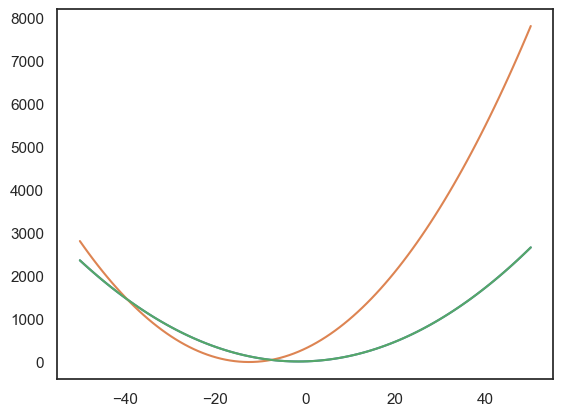

In [123]:
plotCoeff1 = [1,3,2]
plotCoeff2 = [2,50,300]
x = np.linspace(-50,50,100)
y1 = np.polyval(plotCoeff1,x)
y2 = np.polyval(plotCoeff2,x)
plt.plot(x,y1)
plt.plot(x,y2)

p = 0
o = (2/(1+(math.e**(-p/30))))-1

interpolate = y1 + ((y2-y1)*o)

plt.plot(x,interpolate)


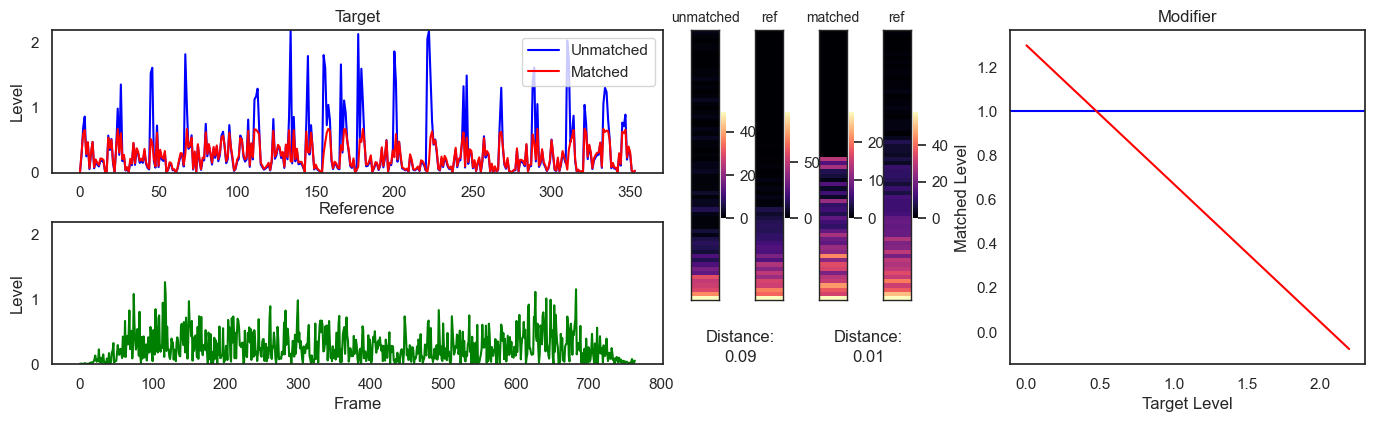

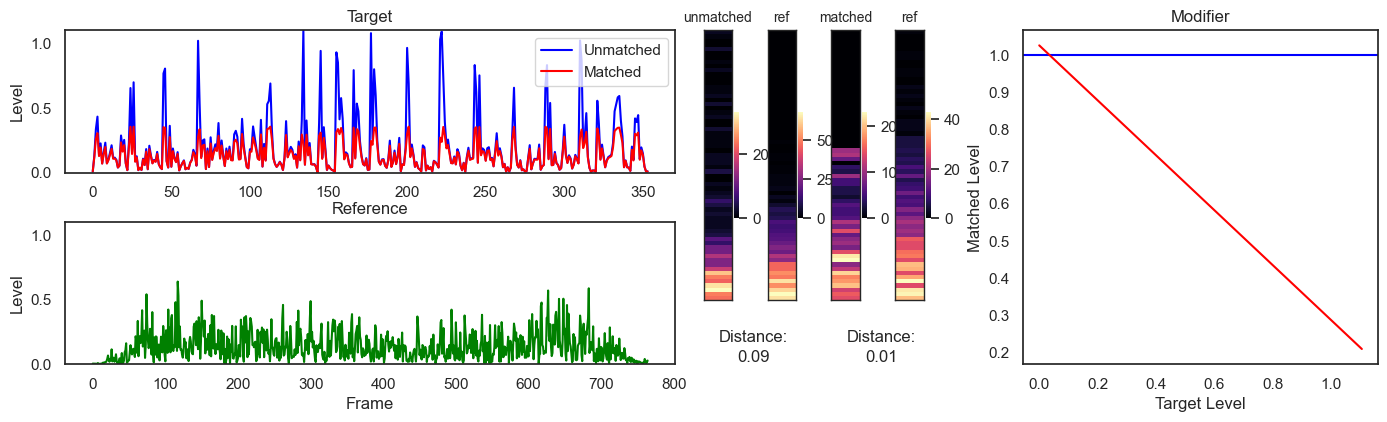

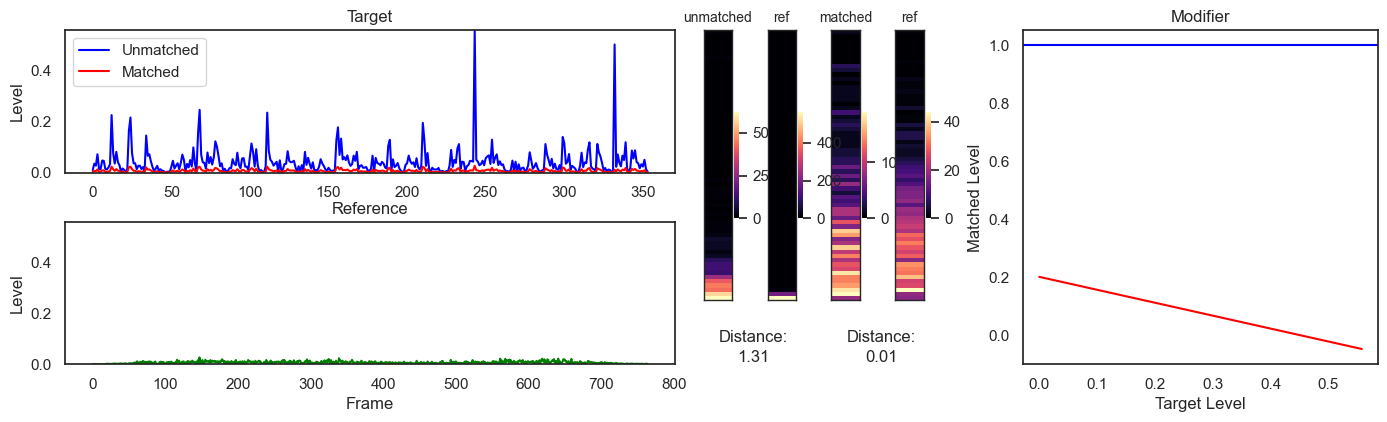

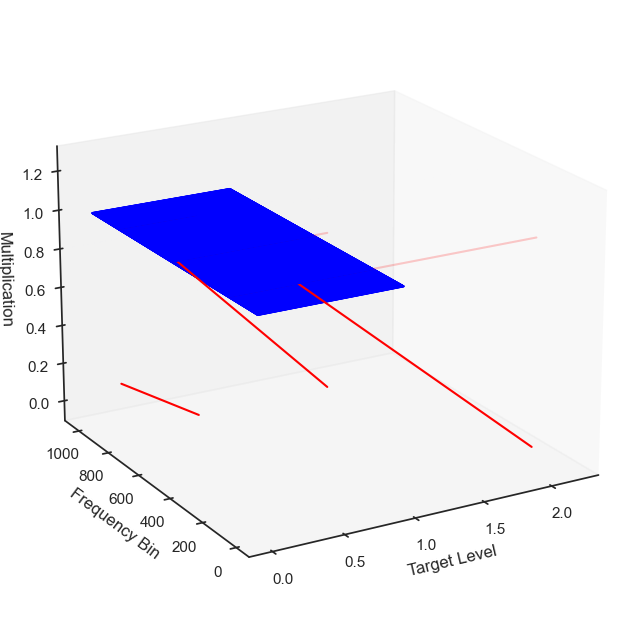

In [165]:
coeffs, centres = findMatchingNew(tAudio,rAudio,tHifi,dynamicBins=64,order=2,searchSize=100,plot=True)

In [ ]:
# Simulated annealing every x bins, local minimisations fill the gaps.
def findMatchingNew(tAudio,rAudio,tHifi,dynamicBins,order,searchSize,plot=False):
    bins = len(tHifi["STFT"])

    coeffs = np.zeros((bins,order))
    maxes = np.zeros(bins)
    optimisation = [None] * bins
    

    # First S.A
    print("SA 0")
    i=0
    tSlice = tAudio["STFT"][i,:]
    rSlice = rAudio["STFT"][i,:]
    coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
    maxes[i]=max(np.abs(tSlice))
    optimisation[i]="SA"

    for block in range(math.floor(bins/jump)):
        # Subblock SA
        i=(block*jump)+jump
        print("SA",i)
        tSlice = tAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]
        coeffs[i]=findMin(tSlice,rSlice,dynamicBins,order,searchSize)
        maxes[i]=max(np.abs(tSlice))
        optimisation[i]="SA"

        for subblock in range(math.floor(jump/2)):
            # right side (!=0 because 0 is SA)
            if(subblock!=0):
                i=(block*jump)+(jump-subblock)
                tSlice = tAudio["STFT"][i,:]
                rSlice = rAudio["STFT"][i,:]
                print(i,":","(bin",(block*jump),"*",(subblock/jump),") + (bin",((block+1)*jump),"*",((jump-subblock)/jump),")")
                initial = (coeffs[block*jump]*(subblock/jump)) + (coeffs[(block+1)*jump]*((jump-subblock)/jump))
                coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
                maxes[i]=max(np.abs(tSlice))
                optimisation[i]="Powell"
            
            # left side
            i=1+(block*jump)+subblock
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((jump-subblock-1)/jump),") + (bin",((block+1)*jump),"*",((subblock+1)/jump),")")
            initial = (coeffs[block*jump]*((jump-subblock-1)/jump)) + (coeffs[(block+1)*jump]*((subblock+1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="Powell"
        
        # middle if jump is odd
        if(jump%2!=0):
            i=(block*jump)+math.ceil(jump/2)
            tSlice = tAudio["STFT"][i,:]
            rSlice = rAudio["STFT"][i,:]
            print(i,":","(bin",(block*jump),"*",((subblock+1)/jump),") + (bin",((block+1)*jump),"*",((jump-subblock-1)/jump),")")
            initial = (coeffs[block*jump]*((subblock+1)/jump)) + (coeffs[(block+1)*jump]*((jump-subblock-1)/jump))
            coeffs[i]=powell(tSlice,rSlice,initial,dynamicBins,order,searchSize)
            maxes[i]=max(np.abs(tSlice))
            optimisation[i]="Powell"

    if(plot):
        plotModifiers(coeffs,maxes,optimisation,plotRange)
    return coeffs


In [18]:
def match(tAudio,coeffs):
    mAudio = copy.deepcopy(tAudio)
    for i in range(len(tAudio["STFT"])):
        bin = tAudio["STFT"][i,:]
        mAudio["STFT"][i,:] = warp(bin,coeffs[i])
    return mAudio

In [19]:
def totalDistance(tAudio,mAudio,rAudio,dynamicBins):
    preDist = 0
    postDist = 0
    for i in range(len(tAudio["STFT"])):
        tSlice = tAudio["STFT"][i,:]
        mSlice = mAudio["STFT"][i,:]
        rSlice = rAudio["STFT"][i,:]

        tMax = max(np.abs(tSlice))
        mMax = max(np.abs(mSlice))
        rMax = max(np.abs(rSlice))

        tDynamicResponse, rDynamicReponse = getDynamicResponse(tSlice,rSlice,dynamicBins)
        preDist += getDistance(tDynamicResponse,rDynamicReponse,tMax,rMax,dynamicBins)
        
        mDynamicResponse, rDynamicReponse = getDynamicResponse(mSlice,rSlice,dynamicBins)
        postDist += getDistance(mDynamicResponse,rDynamicReponse,mMax,rMax,dynamicBins)
    
    print("pre:",preDist/dynamicBins)
    print("post:",postDist/dynamicBins)

<h1>Execution</h1>

In [20]:
frameSize=2048
hopSize=512

figScale = 1

In [1]:
#tAudio, rAudio = importAudio(target="100.wav",reference="tonequiet.wav", output=False)

tAudio, rAudio = importAudio(target="100.wav",reference="tonequiet.wav", numBands=3,output=False)
tHifi, rHifi = importAudio(target="100.wav",reference="tonequiet.wav", numBands=1024,output=False)
#tHifi, rHifi = importAudio(target="audio_mono.wav",reference="audo3_mono.wav", numBands=1024,output=False)
#plotAmpPhase("audio_mono.wav")


#coeffs = findMatching(tAudio,rAudio,dynamicBins=64,order=2,searchSize=100,jump=8,plot=True,plotRange=(0,33))
#coeffs = findMatchingCentreScaleDistanceCheck(tAudio,rAudio,dynamicBins=64,order=2,searchSize=100,plot=True)
#mAudio = match(tAudio,coeffs)
#totalDistance(tAudio,mAudio,rAudio,64)
#plotSpectrogram(tAudio, mAudio, rAudio)


#tSlice = tAudio["STFT"][0,:]
#rSlice = rAudio["STFT"][0,:]
#findMin(tSlice,rSlice,dynamicBins=64,order=2,searchSize=100,plot=True)
#coeffs = findMatchingNew(tAudio,rAudio,tHifi,dynamicBins=64,order=2,searchSize=100,plot=True)

#tSlice = tAudio["STFT"][100,:]
#mSlice1 = warp(np.abs(tSlice), [-1])
#mSlice2 = warp(np.abs(tSlice), [1])
#mSlice1==mSlice2

#plotDynamics(tAudio["STFT"][100,:],rAudio["STFT"][100,:],[-18.73538423,64.65852413,-67.87420381,],64)
#plotDynamics(tAudio["STFT"][100,:],rAudio["STFT"][100,:],[18.73538423,-64.65852413,67.87420381,],64)


#np.abs(tAudio["STFT"][100,5]*-10)

#tAudio, rAudio = importAudio(target="audio_mono.wav",reference="audio2_mono.wav", output=True)

#[-67.87420381,64.65852413,-18.73538423,0]


#mAudio = EQMatching(tAudio,rAudio,smoothing=100, plot=True)
plotSpectrogram(tAudio, tAudio, rAudio)
plotSpectrogram(tHifi, tHifi, rHifi)



#exportAudio(tAudio, mAudio, rAudio)

NameError: name 'importAudio' is not defined

In [183]:
maxTHifi = 0
for i in range(len(tHifi["STFT"])):
    maxVal = max(np.abs(tHifi["STFT"][6,:]))
    if(maxVal>maxTHifi):
        maxTHifi = maxVal

maxTLofi = 0
for i in range(len(tAudio["STFT"])):
    maxVal = max(np.abs(tAudio["STFT"][6,:]))
    if(maxVal>maxTLofi):
        maxTLofi = maxVal

maxRHifi = 0
for i in range(len(rHifi["STFT"])):
    maxVal = max(np.abs(rHifi["STFT"][6,:]))
    if(maxVal>maxRHifi):
        maxRHifi = maxVal

maxRLofi = 0
for i in range(len(rAudio["STFT"])):
    maxVal = max(np.abs(rAudio["STFT"][6,:]))
    if(maxVal>maxRLofi):
        maxRLofi = maxVal

tAudio["STFT"] = tAudio["STFT"] * maxTHifi/maxTLofi
rAudio["STFT"] = rAudio["STFT"] * maxRHifi/maxRLofi

In [180]:
maxTHifi/maxTLofi

215.47173

In [181]:
maxRHifi/maxRLofi

1742.1671

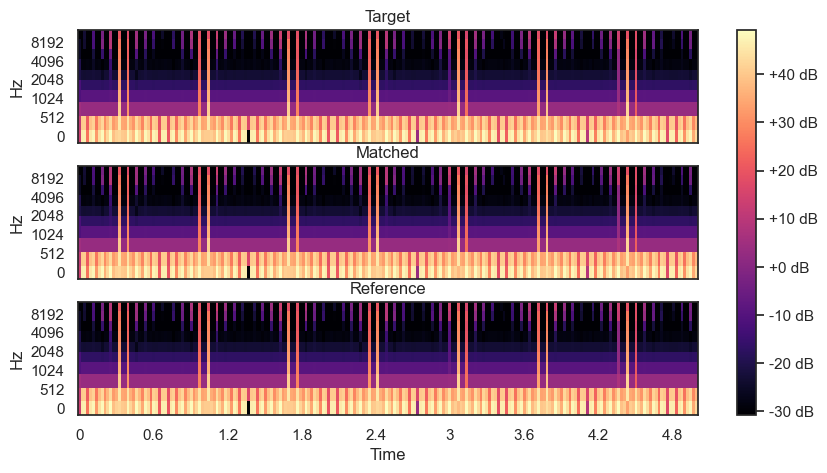

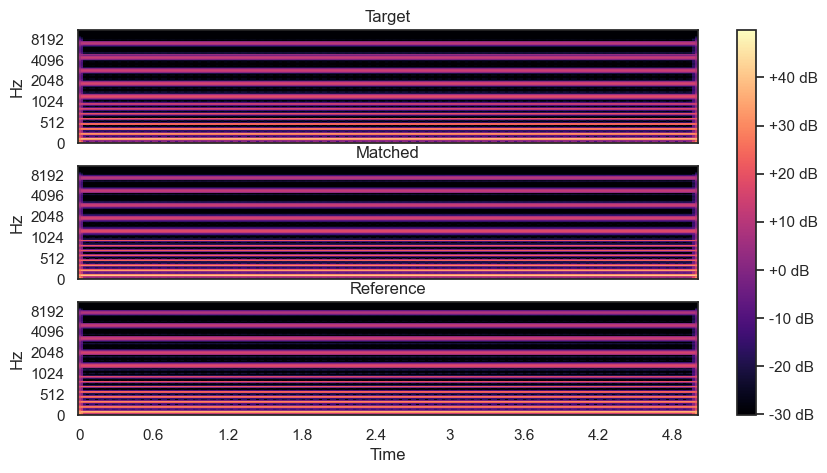

In [186]:
plotSpectrogram(tAudio, tAudio, tAudio)
plotSpectrogram(tHifi, tHifi, tHifi)

In [153]:
print(max(np.abs(tHifi["STFT"][6,:])))
print(max(np.abs(tAudio["STFT"][0,:])))

316.91165
2.1938403


In [ ]:
exportAudio(tAudio, mAudio, rAudio)

Target


Matched


Reference
